In [1]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [2]:
set_plot_sizes(12,14,16)

In [3]:
PATH = "data/bulldozers/"

import feather

In [4]:
df_raw = feather.read_dataframe('tmp/raw')

df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [5]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [6]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid), m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [7]:
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,23,3,204,False,False,False,False,False,False,1248307200
5,1139255,10.184900,1001274,4605,121,3.0,2004,508.0,Low,310G,...,18,3,353,False,False,False,False,False,False,1229558400
6,1139256,9.952278,772701,1937,121,3.0,1993,11540.0,High,790ELC,...,26,3,239,False,False,False,False,False,False,1093478400
7,1139261,10.203592,902002,3539,121,3.0,2001,4883.0,High,416D,...,17,3,321,False,False,False,False,False,False,1132185600
8,1139272,9.975808,1036251,36003,121,3.0,2008,302.0,Low,430HAG,...,27,3,239,False,False,False,False,False,False,1251331200
9,1139275,11.082143,1016474,3883,121,3.0,1000,20700.0,Medium,988B,...,9,3,221,False,False,False,False,False,False,1186617600


# Confidence based on tree variance

In [8]:
set_rf_samples(50000)

In [9]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=2, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2057544530237412, 0.24960186123910383, 0.9115224043264926, 0.8887388324665331, 0.8945897884915655]


In [10]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 1.26 s, sys: 77.6 ms, total: 1.34 s
Wall time: 1.34 s


(9.257519798203369, 0.26989103268400466)

Speed things up

In [11]:
def get_pred(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_pred))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 69.4 ms, sys: 62.9 ms, total: 132 ms
Wall time: 681 ms


(9.257519798203369, 0.26989103268400466)

In [12]:

raw_train, raw_valid = split_vals(df_raw, n_trn)


In [13]:
len(raw_train)

389125

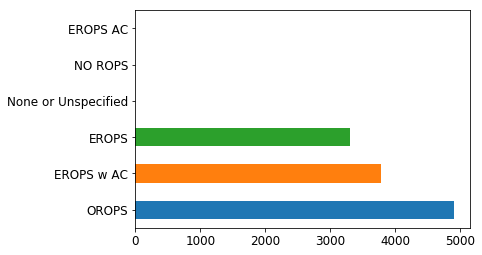

In [14]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [15]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index = False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.843678,0.275106
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.573491,0.269251
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.684113,0.222223


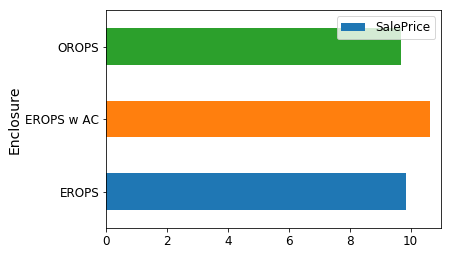

In [16]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11))    

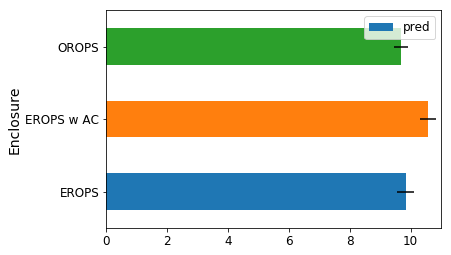

In [17]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', xlim=(0,11))

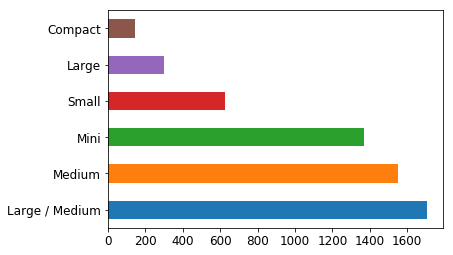

In [18]:
raw_valid.ProductSize.value_counts().plot.barh()

In [19]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.856216,0.335668
Large,10.470589,10.370864,0.353272
Large / Medium,10.691871,10.650225,0.301053
Medium,10.681511,10.618756,0.285372
Mini,9.535147,9.563134,0.246731
Small,10.324448,10.322469,0.315001


In [20]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Large             0.034064
Compact           0.034056
Small             0.030516
Large / Medium    0.028267
Medium            0.026874
Mini              0.025800
dtype: float64

Small groups of data gives more standard deviation.

# Feature Importance

In [21]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.175011
37,Coupler_System,0.127494
13,ProductSize,0.099444
14,fiProductClassDesc,0.070525
2,ModelID,0.058303
63,saleElapsed,0.050180
10,fiSecondaryDesc,0.043635
39,Hydraulics_Flow,0.041812
19,Enclosure,0.036745
8,fiModelDesc,0.032610


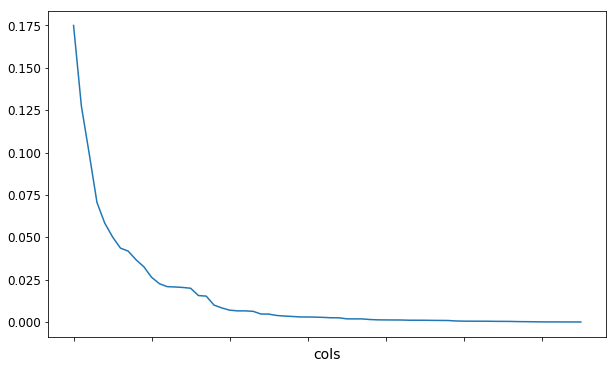

In [22]:
fi.plot('cols', 'imp', figsize = (10,6), legend=False);

In [23]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,17), legend=False)

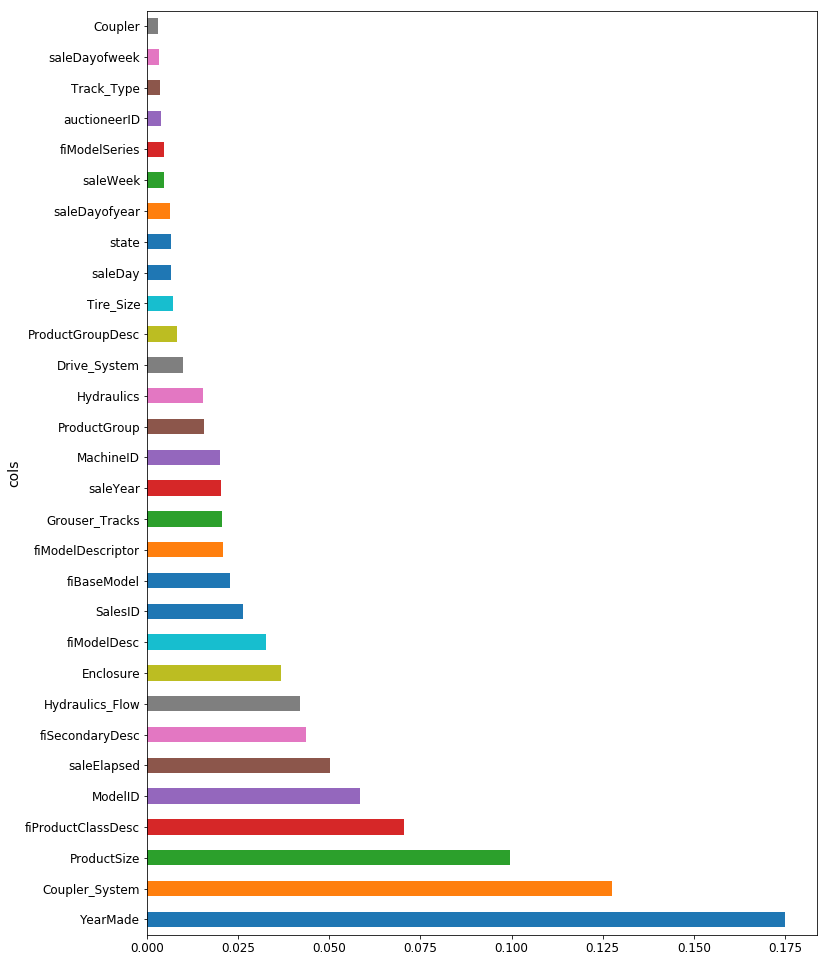

In [24]:
plot_fi(fi[:30])

In [25]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

24

In [26]:
df_keep = df_trn[to_keep].copy()

In [27]:
X_train, X_valid = split_vals(df_keep, n_trn)

In [28]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=2, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2069067846038011, 0.2457426379560591, 0.910528588367527, 0.892152767283454, 0.8941327245345334]


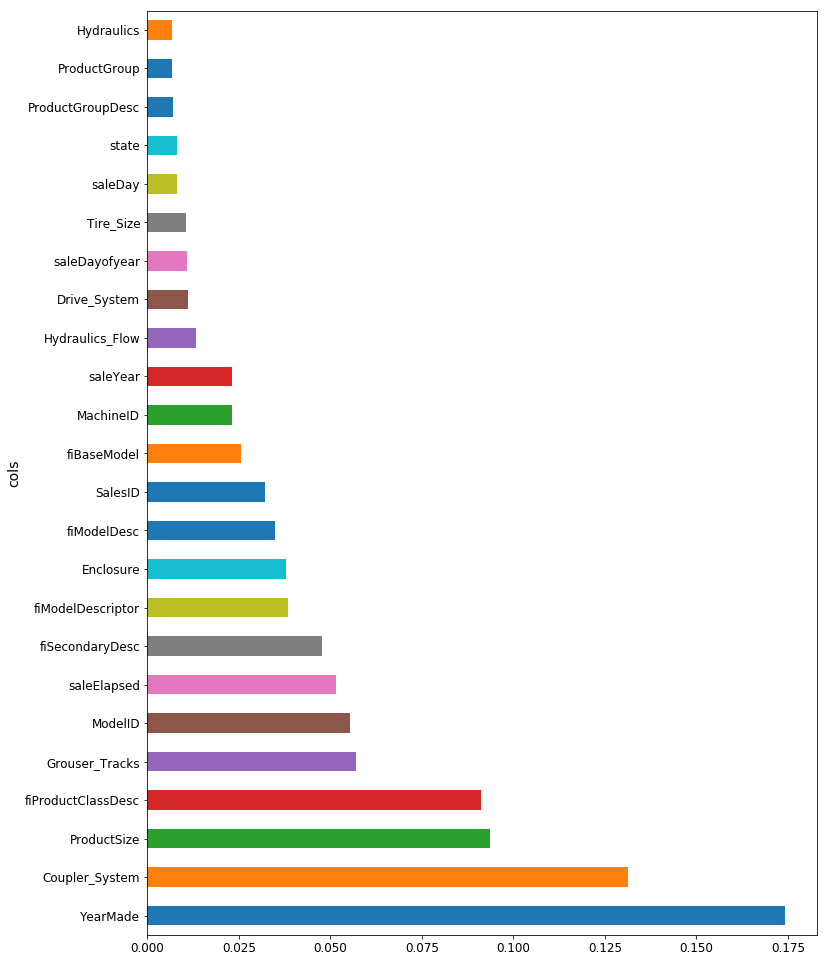

In [29]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi)

# One-hot encoding

In [30]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2070514664119362, 0.2529271046642679, 0.9104034169135136, 0.8857546009196059, 0.8927751647253621]


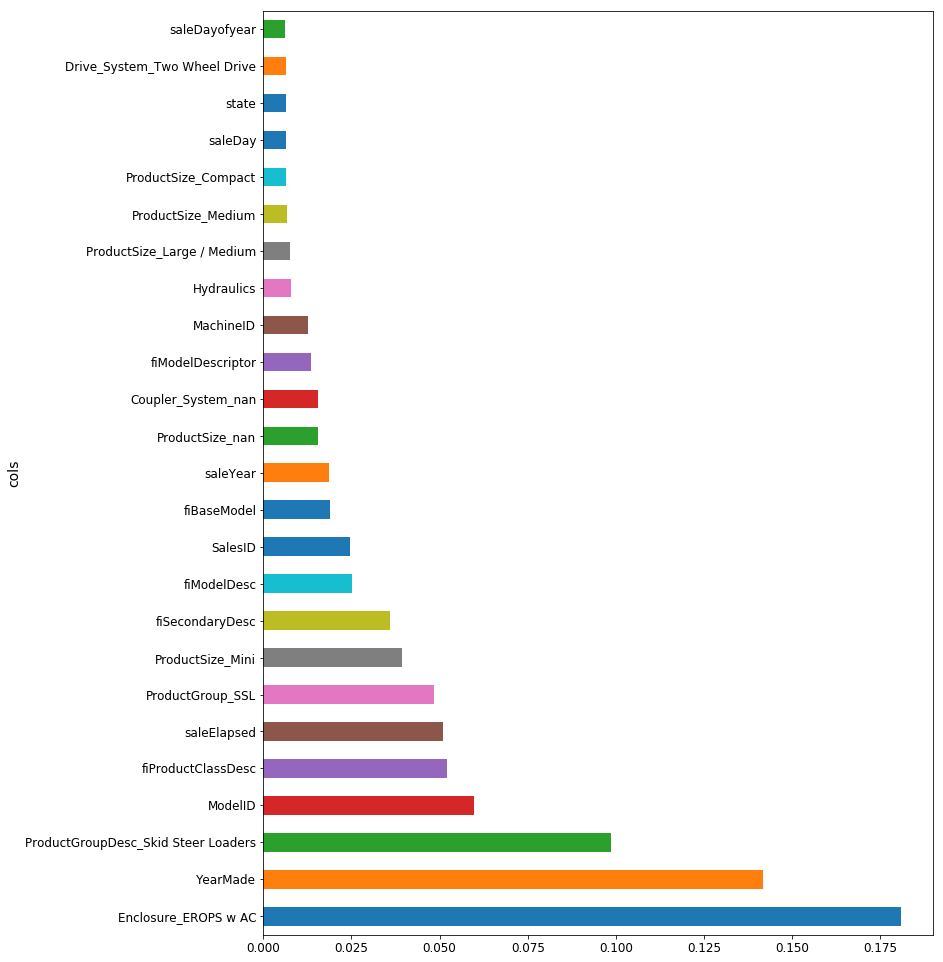

In [31]:
fi = rf_feat_importance(m, df_trn2
                       )
plot_fi(fi[:25])

# Removing Redundant Features

In [32]:
from scipy.cluster import hierarchy as hc

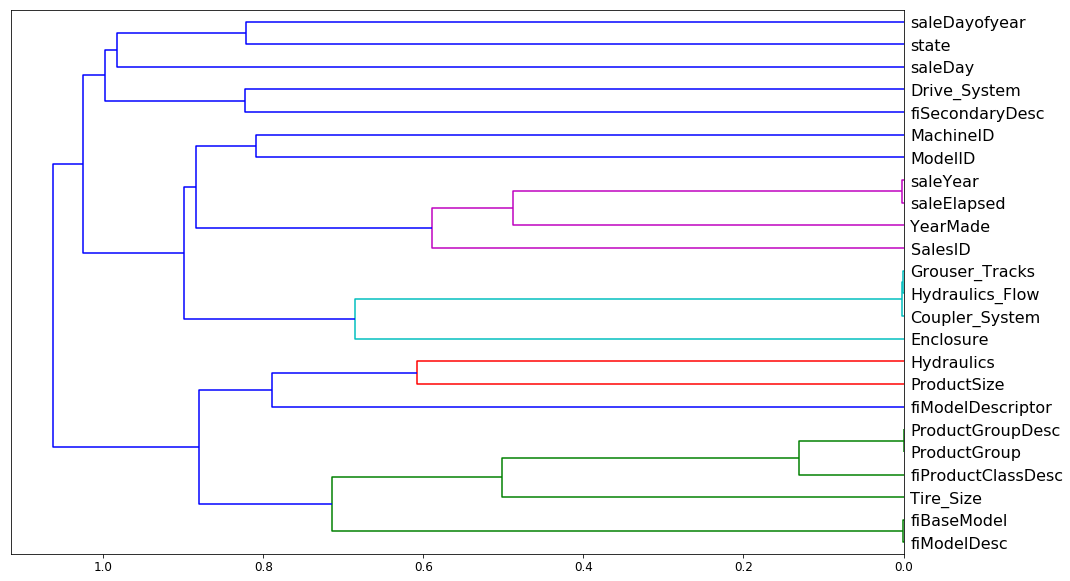

In [33]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16, 10))
dendogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()


###### This dendrogram basically tells us which groups are similar and here we have four to five similar groups

- saleYear and saleElapsed
- [Grouser_Tracks and Hydraulics_flow] and Coupler_System
- ProudctGroup and ProductGroupDesc
- fiBaseModel and fiModelDesc

We will remove some of this features that are similar and then again build a model

In [34]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [35]:
get_oob(df_keep)

0.8930381055288553

In [36]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.8919971566910629
saleElapsed 0.8897194493817352
fiModelDesc 0.8909450821607247
fiBaseModel 0.8924083036227803
Grouser_Tracks 0.8930460391454857
Coupler_System 0.8929779991409071


We can only drop one from a group

In [37]:
to_drop = ['saleYear', 'fiModelDesc', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8897155534655505

In [38]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [39]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [40]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

Full dataset training

In [41]:
reset_rf_samples()

In [42]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12586561039470834, 0.2273659492439585, 0.9668907762578318, 0.9076793565157392, 0.9088354654512998]


# Partial Dependance

In [43]:
from pdpbox import pdp
from plotnine import *

In [44]:
set_rf_samples(50000)

In [45]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1)
m.fit(X_train, y_train);

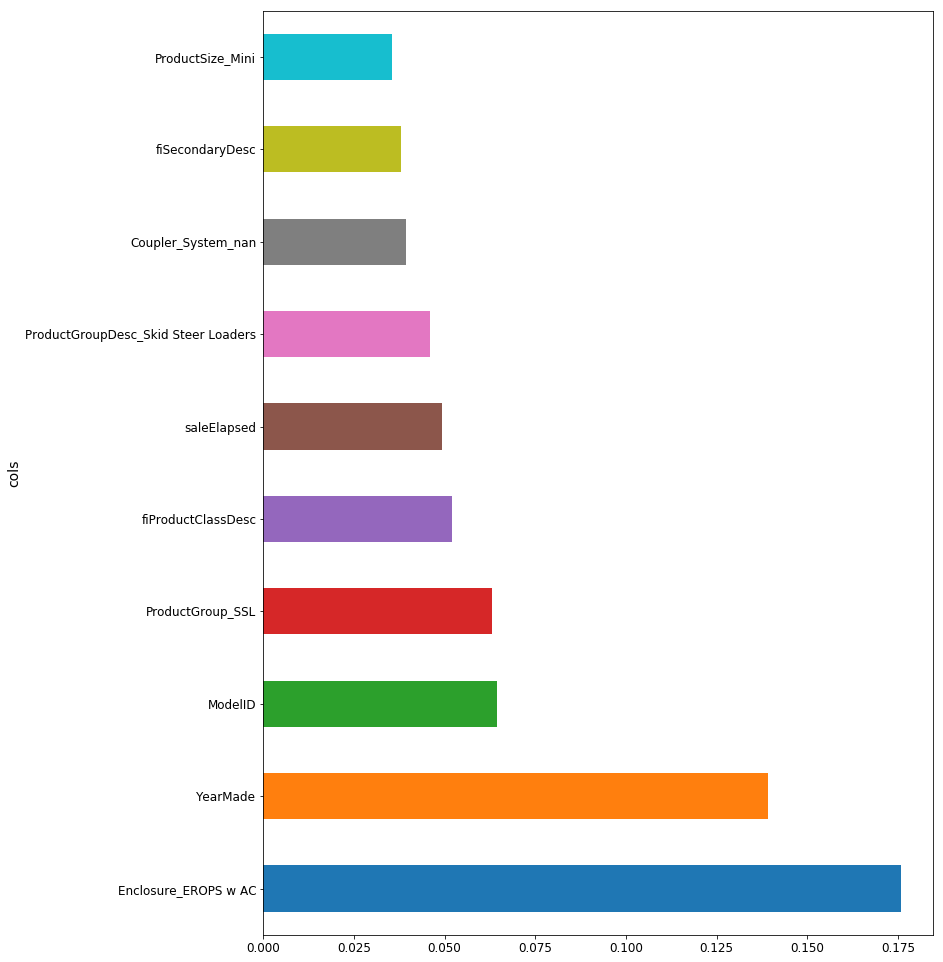

In [46]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

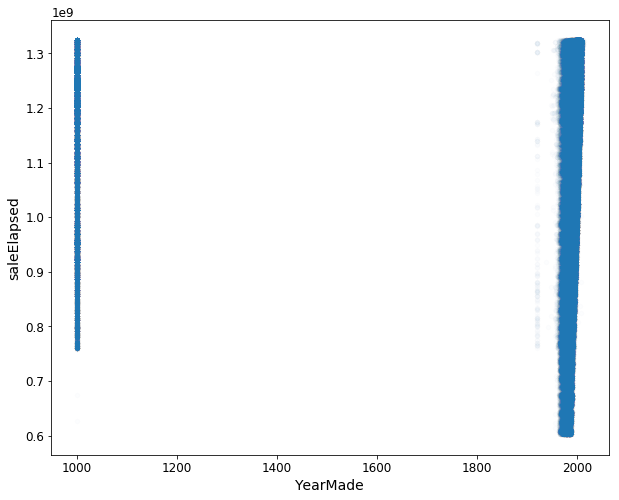

In [47]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8))

Relation between YearMade and saleElapsed. Here for a bunch of rows we have YearMade or 1000 which is not possible and there could be various reasons for that.

In [48]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

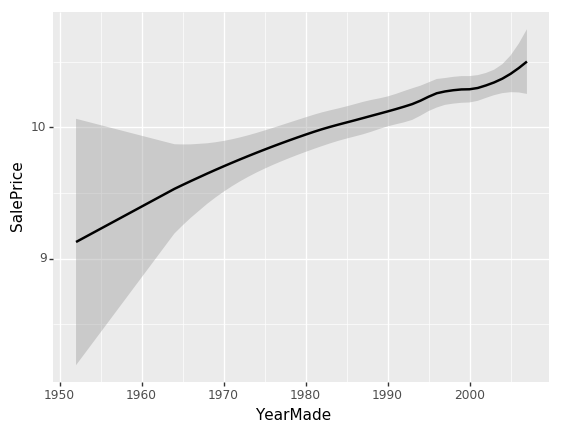

<ggplot: (-9223372036542169782)>

In [49]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [50]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [53]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, x.columns, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, cluster=clusters is not None, n_cluster_centers=clusters)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x12d6efa90>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x12b8b8860>})

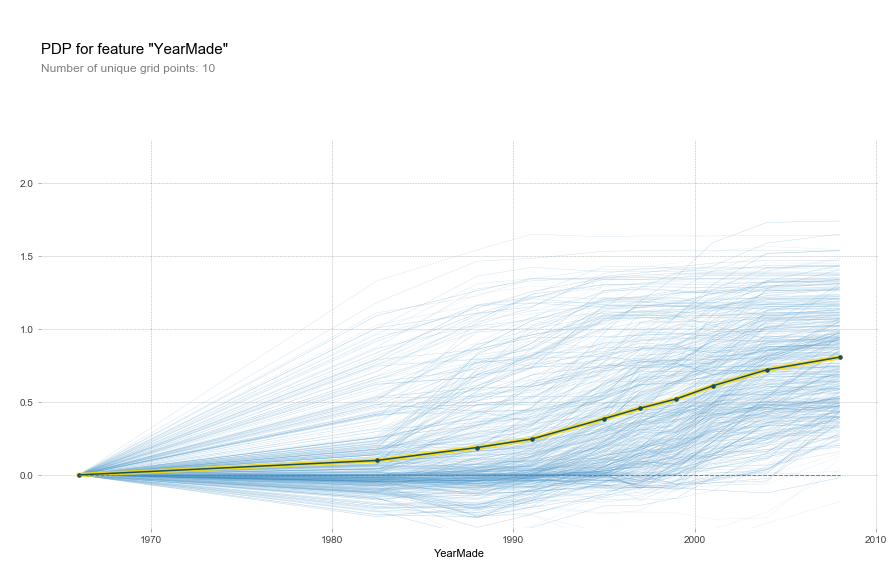

In [54]:
plot_pdp('YearMade')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x135d09eb8>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x135d33e48>})

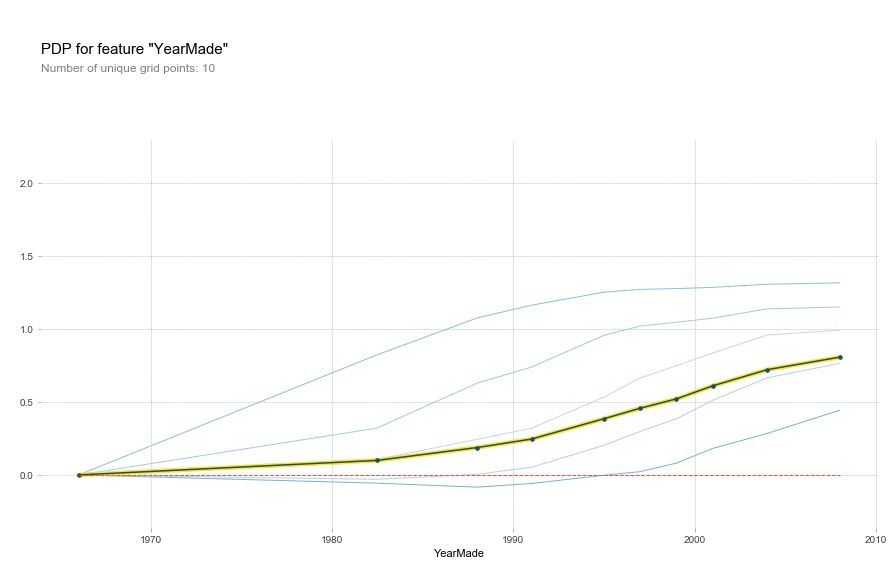

In [55]:
plot_pdp('YearMade', clusters=5)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x137fd5e48>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x12ca3a240>})

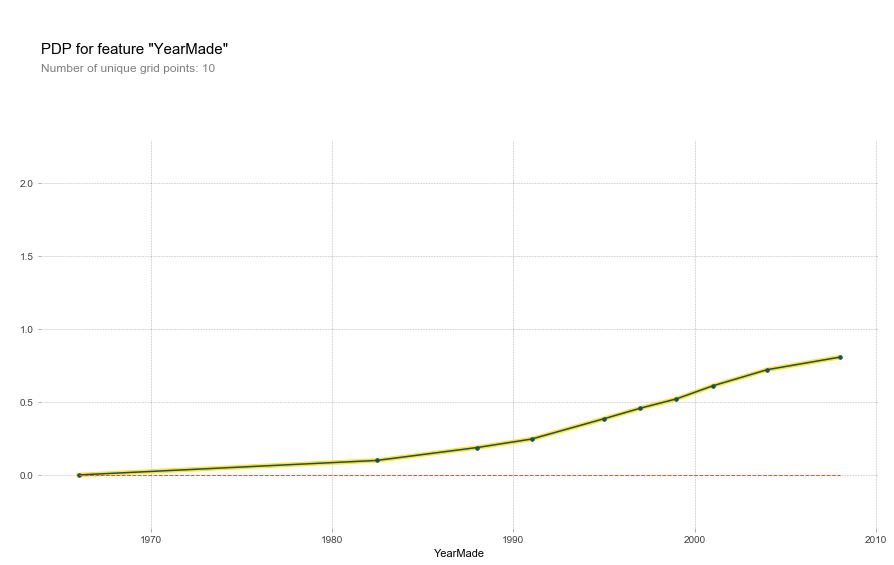

In [56]:
plot_pdp('YearMade', clusters=1)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x12ed67908>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x12fe04438>})

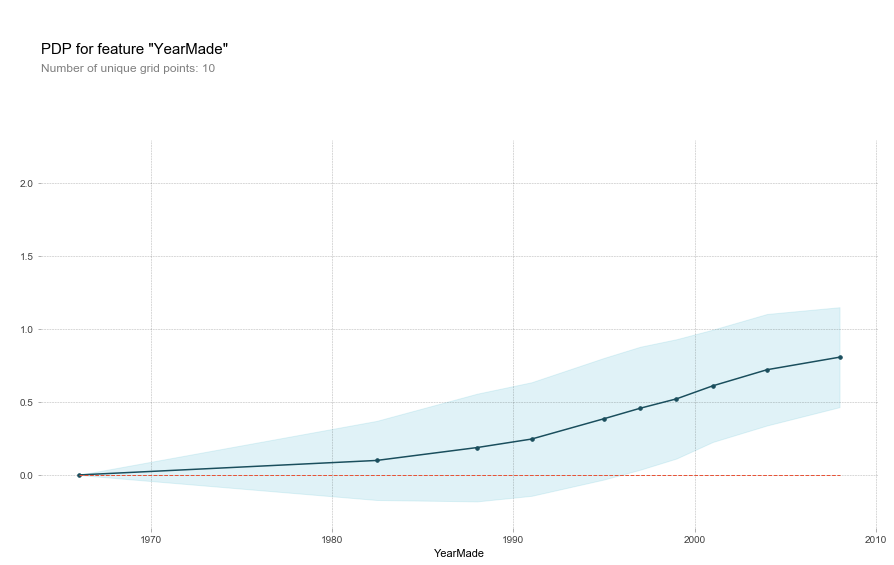

In [57]:
p = pdp.pdp_isolate(m, x, x.columns, 'YearMade')
pdp.pdp_plot(p,'YearMade', plot_lines=False)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x136cd3828>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x137f78cc0>})

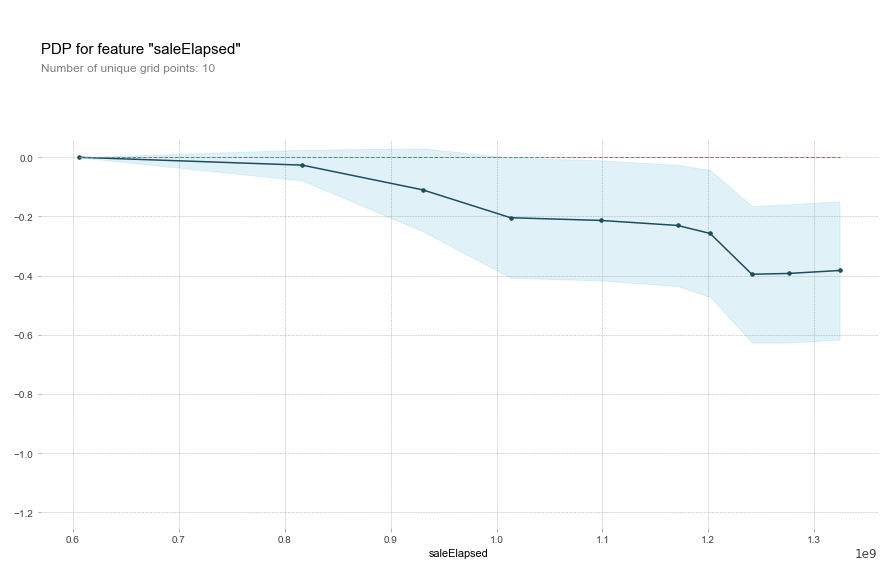

In [58]:
p = pdp.pdp_isolate(m, x, x.columns, 'saleElapsed')
pdp.pdp_plot(p,'saleElapsed', plot_lines=False)

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x139caaba8>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x13a6e6208>})

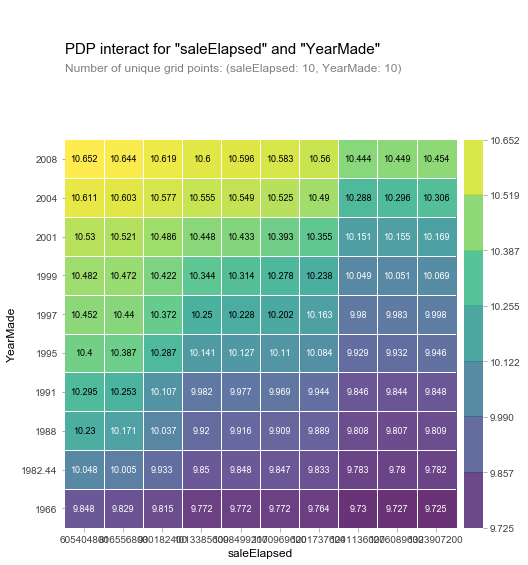

In [60]:
feats = ['saleElapsed', 'YearMade']
# for i in feats:
#     p = pdp.pdp_interact(m, x, x.columns, i)
#     pdp.pdp_interact(p, i)
# p = pdp.pdp_interact(m, x, x.columns, 'saleElapsed')
# pdp.pdp_interact_plot(p, 'saleElapsed')
p = pdp.pdp_interact(m, x, x.columns, feats)
# pdp.pdp_interact_plot(p, feats)
pdp.pdp_interact_plot(p, feats, plot_type='grid')


(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x13d2e5b70>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x128c7c780>})

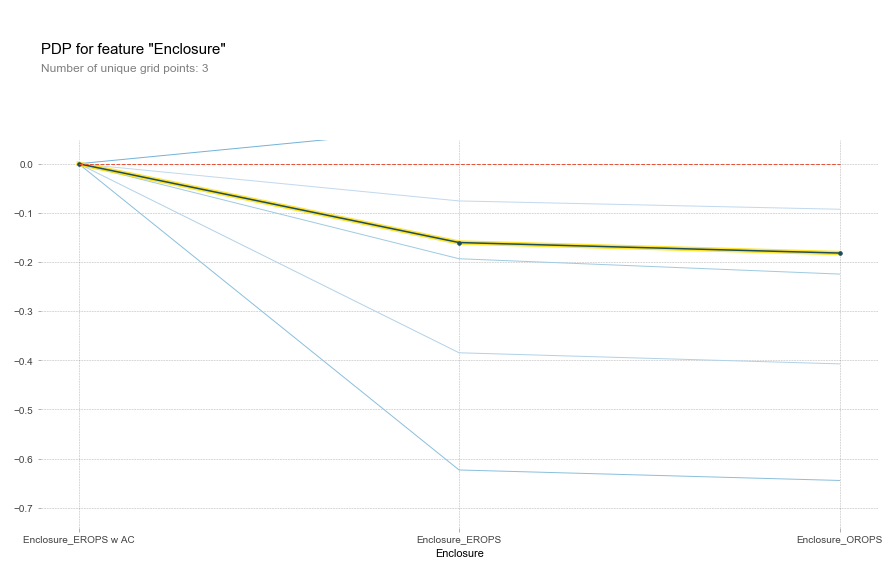

In [61]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

In [63]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

In [64]:
df_keep.head()

,YearMade,Coupler_System,ProductSize,fiProductClassDesc,ModelID,saleElapsed,fiSecondaryDesc,Hydraulics_Flow,Enclosure,SalesID,...,MachineID,ProductGroup,Hydraulics,Drive_System,ProductGroupDesc,Tire_Size,saleDay,state,saleDayofyear,age
0,2004,0,0,59,3157,1163635200,41,0,3,1139246,...,999089,6,1,0,6,17,16,1,320,2
1,1996,0,4,62,77,1080259200,55,0,3,1139248,...,117657,6,1,0,6,12,26,33,86,8
2,2001,1,0,39,7009,1077753600,0,3,6,1139249,...,434808,3,4,0,3,0,26,32,57,3
3,2001,0,6,8,332,1305763200,0,0,3,1139251,...,1026470,4,1,0,4,0,19,44,139,10
4,2007,1,0,40,17311,1248307200,0,3,1,1139253,...,1057373,3,4,0,3,0,23,32,204,2


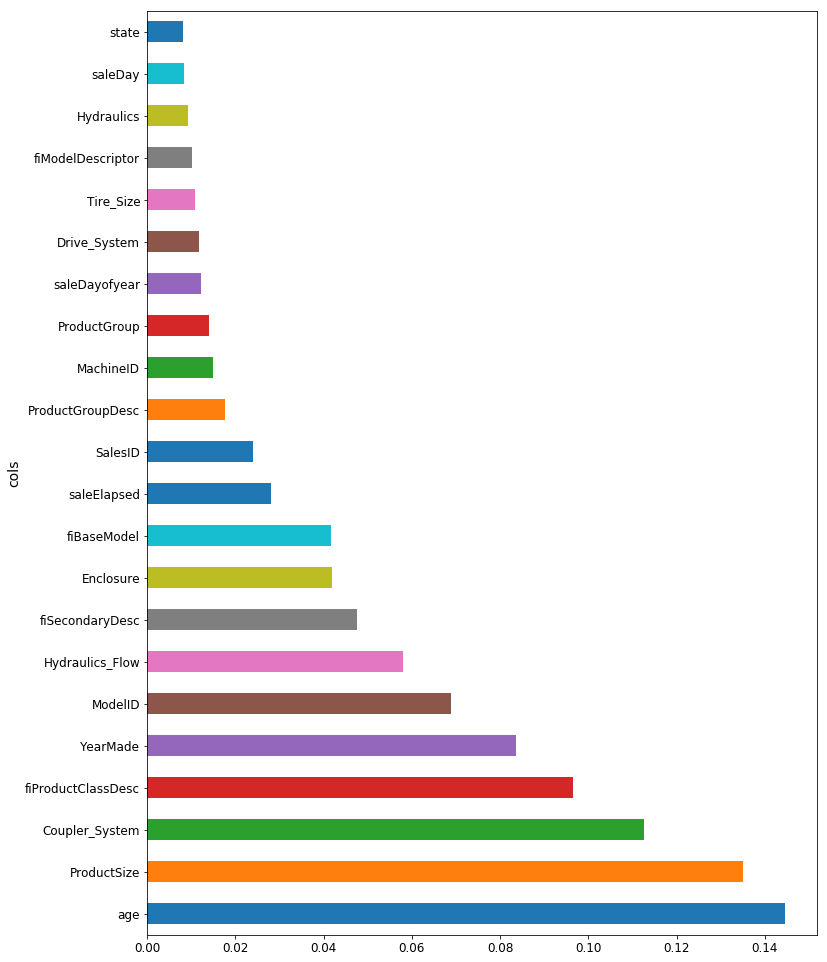

In [65]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep))

# Tree Interpreter

In [66]:
from treeinterpreter import treeinterpreter as ti

In [67]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [68]:
row = X_valid.values[None,0]; row

array([[      1999,          0,          5,         17,        665, 1284595200,          0,          0,
                 1,    4364751,       1111,          0,    2300944,          4,         12,          0,
                 4,          0,         16,         35,        259,         11]])

In [69]:
prediction, bias, contributions = ti.predict(m, row)

In [70]:
prediction[0], bias[0]

(array([9.25382]), 10.104421062357435)

In [71]:
idxs = np.argsort(contributions[0])

In [72]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.5678675566748754),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.15394632700625993),
 ('age', 11, -0.1099533773285628),
 ('fiBaseModel', 'KX121', -0.058161379277711055),
 ('Enclosure', 'EROPS', -0.03769074026023307),
 ('SalesID', 4364751, -0.027284768203585764),
 ('fiSecondaryDesc', nan, -0.026591067191683714),
 ('saleElapsed', 1284595200, -0.015599826134698435),
 ('fiModelDescriptor', nan, -0.014526068636194055),
 ('Tire_Size', nan, -0.010443351409919721),
 ('state', 'Ohio', -0.009487107917127525),
 ('saleDayofyear', 259, -0.006500519405580274),
 ('MachineID', 2300944, -0.006443141301511001),
 ('saleDay', 16, 0.0009046247071966551),
 ('Hydraulics', 'Standard', 0.003073989289414758),
 ('Drive_System', nan, 0.003120466744523975),
 ('ProductGroup', 'TEX', 0.0057498036130433135),
 ('ProductGroupDesc', 'Track Excavators', 0.015525157063621852),
 ('Hydraulics_Flow', nan, 0.02390711861743413),
 ('ModelID', 665, 0.02876670321

In [73]:
contributions[0].sum()

-0.8506059526616127

# Extrapolation

In [75]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x,y,nas = proc_df(df_ext, 'is_valid')

In [76]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x,y)
m.oob_score_

0.9999850420691805

In [77]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
9,SalesID,0.773798
5,saleElapsed,0.171790
12,MachineID,0.047113
4,ModelID,0.002003
10,fiBaseModel,0.001946
1,Coupler_System,0.001275
20,saleDayofyear,0.000940
21,age,0.000274
14,Hydraulics,0.000231
3,fiProductClassDesc,0.000146


In [78]:
feats = ['SalesID', 'saleElapsed', 'MachineID']

In [79]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+06,1206.796148
std,595.627288,1.803913e+05,430.850552
min,1139.246000,6.009984e+05,0.000000
25%,1413.348000,9.666432e+05,1087.016000
50%,1632.093000,1.134605e+06,1273.859000
75%,2210.453000,1.234138e+06,1458.661000
max,4364.741000,1.325117e+06,2313.821000


In [80]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


In [81]:
x.drop(feats, axis=1, inplace=True)

In [82]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x,y)
m.oob_score_

0.9789367404175756

In [83]:
fi = rf_feat_importance(m,x); fi[:10]

,cols,imp
18,age,0.229053
0,YearMade,0.185779
17,saleDayofyear,0.162229
4,ModelID,0.082495
15,saleDay,0.058308
8,fiBaseModel,0.058272
16,state,0.055831
3,fiProductClassDesc,0.033073
5,fiSecondaryDesc,0.024405
11,Hydraulics,0.021507


In [94]:
set_rf_samples(50000)

In [95]:
feats = ['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [96]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20797932495927976, 0.24819974122433303, 0.9095986003286199, 0.889985324344559, 0.8930349165286875]


In [97]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.20990837728161268, 0.2468525136849531, 0.907913838849364, 0.8911764017024674, 0.8917102813459246]
saleElapsed
[0.21463567936374456, 0.2545786675667472, 0.9037194282054497, 0.8842577309372381, 0.8866541521129162]
MachineID
[0.20681626258445035, 0.24522595450648105, 0.9106068589875981, 0.8926057965251799, 0.8949990418673643]
age
[0.2095251716746268, 0.2487162977993506, 0.9082497541965515, 0.8895269198336929, 0.8917099577929446]
YearMade
[0.20951766663400173, 0.251504287940835, 0.9082563269341773, 0.8870363382745972, 0.8916872597287766]
saleDayofyear
[0.20922253040562738, 0.2447990529170572, 0.9085146136095656, 0.892979385447193, 0.8925060629457978]


In [102]:
reset_rf_samples()

In [103]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.13877411874150522, 0.2180371867656332, 0.9597513069757241, 0.9150997217164066, 0.9092160771226948]


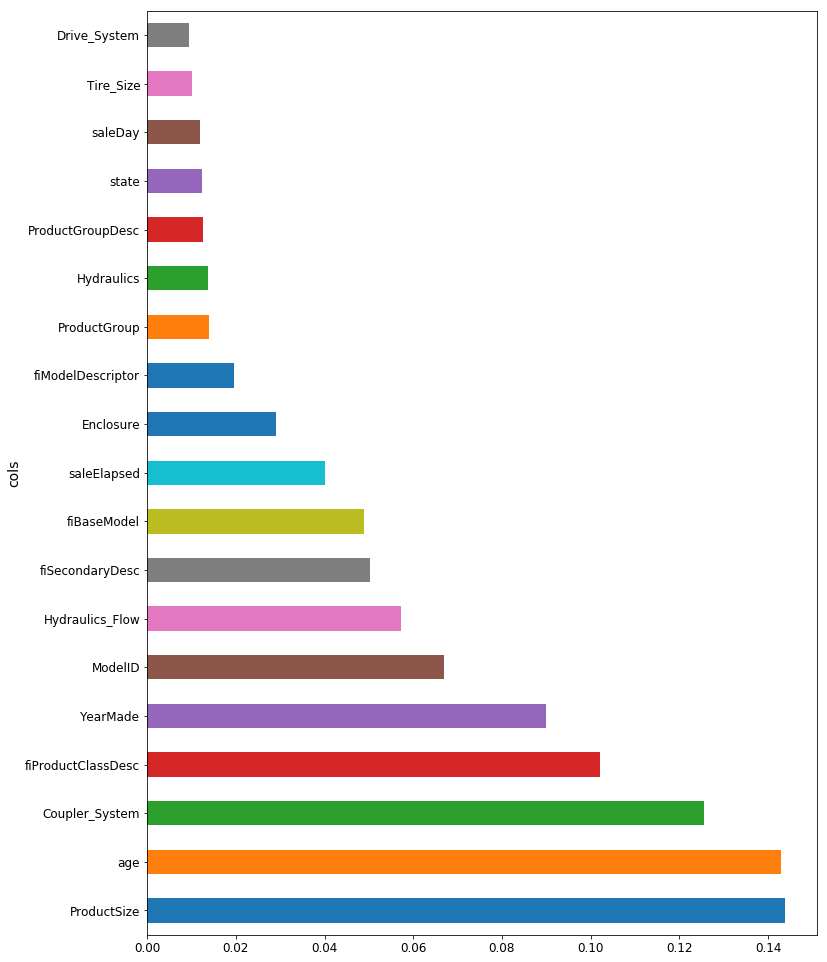

In [104]:
plot_fi(rf_feat_importance(m, X_train))

In [105]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

# Final Model

In [106]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 3min 53s, sys: 9.68 s, total: 4min 2s
Wall time: 1min 22s
[0.08026874250725098, 0.21192414229229153, 0.9865343368927623, 0.919793633529369, 0.9144123898919378]
